In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# Caricare il dataset
file_path = '/content/evaluation.csv'  # Cambia con il percorso corretto del tuo dataset
df = pd.read_csv(file_path, delimiter=';')

# Mostra una parte del dataset per assicurarti che sia caricato correttamente
print(df.head())

# Preparare il tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Classe per il dataset personalizzato
class FakeNewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0).to(torch.long),
            'attention_mask': encoding['attention_mask'].squeeze(0).to(torch.long),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Parametri
MAX_LEN = 128  # Puoi aumentarlo fino a 512 se la tua GPU lo permette
BATCH_SIZE = 8
gradient_accumulation_steps = 2  # Quanti passi di batch accumulare prima di aggiornare i pesi
epochs = 3  # Numero di epoche

# Suddividere il dataset in training e validation
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['text'].values,
    df['label'].values,
    test_size=0.2,  # Percentuale del dataset da usare per la validazione
    random_state=42
)

# Creare i dataset e i dataloader per training e validazione
train_dataset = FakeNewsDataset(texts=train_texts, labels=train_labels, tokenizer=tokenizer, max_len=MAX_LEN)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = FakeNewsDataset(texts=val_texts, labels=val_labels, tokenizer=tokenizer, max_len=MAX_LEN)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Caricare il modello BERT pre-addestrato per la classificazione binaria
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Impostare il dispositivo (GPU o CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Spostare il modello sulla GPU (se disponibile)
model.to(device)

# Impostare l'ottimizzatore
optimizer = AdamW(model.parameters(), lr=1e-5)

# Funzione di addestramento con accumulo dei gradienti
def train_model(model, train_dataloader, optimizer, device, gradient_accumulation_steps):
    model.train()  # Impostiamo il modello in modalità addestramento
    total_loss = 0

    for batch_idx, batch in enumerate(tqdm(train_dataloader, desc="Training")):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()  # Azzerare i gradienti all'inizio del batch

        # Passare i dati nel modello
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        loss.backward()

        if (batch_idx + 1) % gradient_accumulation_steps == 0:
            optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_dataloader)
    print(f"Average Training Loss: {avg_loss}")

# Funzione di validazione
def validate_model(model, val_dataloader, device):
    model.eval()  # Impostiamo il modello in modalità valutazione
    total_loss = 0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():  # Disabilitiamo il calcolo del gradiente
        for batch in tqdm(val_dataloader, desc="Validation"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Passare i dati nel modello
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            total_loss += loss.item()

            preds = torch.argmax(logits, dim=1)
            total_correct += (preds == labels).sum().item()
            total_samples += labels.size(0)

    avg_loss = total_loss / len(val_dataloader)
    accuracy = total_correct / total_samples
    print(f"Validation Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")
    return avg_loss, accuracy

# Addestramento del modello con validazione e salvataggio del miglior modello
best_val_loss = float('inf')

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    train_model(model, train_dataloader, optimizer, device, gradient_accumulation_steps)
    val_loss, val_accuracy = validate_model(model, val_dataloader, device)

    # Salvare il modello migliore
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        model.save_pretrained('./best_fake_news_model')
        print("Best model saved!")

# Salvataggio finale del modello
model.save_pretrained('./fake_news_model')


   Unnamed: 0                                              title  \
0           0  Sanders back in U.S. Senate, blasts 'coloniali...   
1           1  Kremlin: Syria peoples' congress being 'active...   
2           2   Oregon Cop Convicted Of Shattering Biker’s Co...   
3           3   Twitter Erupts With Glee Over #CruzSexScandal...   
4           4  MUST WATCH VIDEO: Obama Tries To Trash Trump B...   

                                                text  label  
0  WASHINGTON (Reuters) - Democratic U.S. preside...      1  
1  MOSCOW (Reuters) - A proposal to convene a con...      1  
2  In a baffling fit of rage, an Oregon State Pol...      0  
3  The last thing any politician running for the ...      0  
4  This is too good to miss! Mr. Teleprompter did...      0  


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3


Training: 100%|██████████| 812/812 [03:21<00:00,  4.02it/s]


Average Training Loss: 0.10426561125288052


Validation: 100%|██████████| 203/203 [00:25<00:00,  7.97it/s]


Validation Loss: 0.0384, Accuracy: 0.9815
Best model saved!
Epoch 2/3


Training: 100%|██████████| 812/812 [03:23<00:00,  3.99it/s]


Average Training Loss: 0.04249780640502694


Validation: 100%|██████████| 203/203 [00:25<00:00,  7.89it/s]


Validation Loss: 0.0363, Accuracy: 0.9791
Best model saved!
Epoch 3/3


Training: 100%|██████████| 812/812 [03:22<00:00,  4.00it/s]


Average Training Loss: 0.03505410335391985


Validation: 100%|██████████| 203/203 [00:26<00:00,  7.65it/s]


Validation Loss: 0.0293, Accuracy: 0.9865
Best model saved!


In [ ]:
tokenizer.save_pretrained('/content/fake_news_model')


('/content/fake_news_model/tokenizer_config.json',
 '/content/fake_news_model/special_tokens_map.json',
 '/content/fake_news_model/vocab.txt',
 '/content/fake_news_model/added_tokens.json')

In [ ]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.metrics import accuracy_score, classification_report

# Specifica il percorso della directory del modello
model_path = '/content/fake_news_model'  # Cambia con il percorso corretto della directory del modello

# Carica il tokenizer e il modello salvati
tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertForSequenceClassification.from_pretrained(model_path)

# Imposta il dispositivo (GPU o CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Funzione per preparare i dati di test
def prepare_test_data(texts, tokenizer, max_len):
    input_ids, attention_masks = [], []
    for text in texts:
        encoding = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        input_ids.append(encoding['input_ids'].squeeze(0))
        attention_masks.append(encoding['attention_mask'].squeeze(0))
    return torch.stack(input_ids), torch.stack(attention_masks)

# Carica i dati di test
test_file_path = '/content/evaluation.csv'  # Percorso ai dati di test
df_test = pd.read_csv(test_file_path, delimiter=';')

# Estrarre testi e etichette dai dati di test
test_texts = df_test['text'].values  # Sostituire con il nome corretto della colonna nel file di test
test_labels = df_test['label'].values  # Sostituire con il nome corretto della colonna delle etichette

# Prepara i dati di test
MAX_LEN = 128  # Deve corrispondere alla lunghezza massima utilizzata durante l'addestramento
test_input_ids, test_attention_masks = prepare_test_data(test_texts, tokenizer, MAX_LEN)

# Convertire le etichette di test in tensori
test_labels = torch.tensor(test_labels)

# Funzione per testare il modello
def test_model(model, input_ids, attention_masks, labels, device):
    model.eval()  # Modalità valutazione
    predictions = []
    true_labels = []

    with torch.no_grad():  # Disabilitare il calcolo dei gradienti
        for i in range(len(input_ids)):
            # Preparare i batch (batch size = 1)
            input_id = input_ids[i].unsqueeze(0).to(device)
            attention_mask = attention_masks[i].unsqueeze(0).to(device)
            label = labels[i].to(device)

            # Ottieni le previsioni
            outputs = model(input_ids=input_id, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1).item()

            # Salvare le previsioni e i valori reali
            predictions.append(preds)
            true_labels.append(label.item())

    return predictions, true_labels

# Esegui il test
predictions, true_labels = test_model(model, test_input_ids, test_attention_masks, test_labels, device)

# Calcola le metriche di valutazione
accuracy = accuracy_score(true_labels, predictions)
report = classification_report(true_labels, predictions, target_names=['Fake', 'Real'])

print(f"Test Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(report)


Test Accuracy: 0.9925
Classification Report:
              precision    recall  f1-score   support

        Fake       0.99      0.99      0.99      3803
        Real       0.99      0.99      0.99      4314

    accuracy                           0.99      8117
   macro avg       0.99      0.99      0.99      8117
weighted avg       0.99      0.99      0.99      8117



                                                text Actual Predicted_Label  \
0  WASHINGTON (Reuters) - Democratic U.S. preside...   Fake            Fake   
1  MOSCOW (Reuters) - A proposal to convene a con...   Fake            Fake   
2  In a baffling fit of rage, an Oregon State Pol...   Real            Real   
3  The last thing any politician running for the ...   Real            Real   
4  This is too good to miss! Mr. Teleprompter did...   Real            Real   

   Verdict  
0  Correct  
1  Correct  
2  Correct  
3  Correct  
4  Correct  


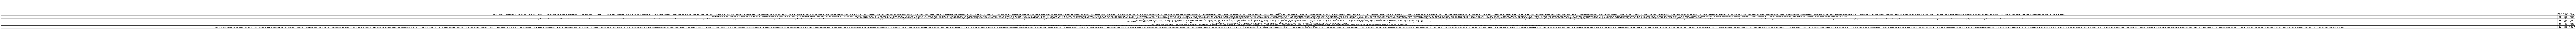

In [10]:
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification
import torch

# Caricare il modello e il tokenizer
model_path = '/content/fake_news_model'  # Percorso del modello salvato
tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertForSequenceClassification.from_pretrained(model_path)
model.eval()

# Caricare il dataset di test
test_file_path = '/content/evaluation.csv'  # Cambia con il percorso del dataset di test
df_test = pd.read_csv(test_file_path, delimiter=';')

# Prepara i dati per la predizione
def predict(text, tokenizer, model):
    # Tokenizza il testo
    inputs = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=128,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )
    input_ids = inputs['input_ids']
    attention_mask = inputs['attention_mask']

    # Esegui la predizione
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        prediction = torch.argmax(logits, dim=1).item()

    return prediction

# Aggiungi le predizioni al DataFrame
df_test['Predicted'] = df_test['text'].apply(lambda x: predict(x, tokenizer, model))

# Aggiungi una colonna con il verdetto
df_test['Verdict'] = df_test.apply(
    lambda row: 'Correct' if row['label'] == row['Predicted'] else 'Incorrect',
    axis=1
)

# Mappa le etichette in parole comprensibili
label_mapping = {0: 'Real', 1: 'Fake'}
df_test['Actual'] = df_test['label'].map(label_mapping)
df_test['Predicted_Label'] = df_test['Predicted'].map(label_mapping)

# Mostra le prime righe in formato tabellare
print(df_test[['text', 'Actual', 'Predicted_Label', 'Verdict']].head())

# Visualizzazione con Matplotlib (opzionale)
import matplotlib.pyplot as plt

# Seleziona un campione di notizie
sample_size = 10
sample = df_test.sample(n=sample_size, random_state=42)

# Crea una tabella visiva
fig, ax = plt.subplots(figsize=(12, 6))
ax.axis('tight')
ax.axis('off')
table_data = sample[['text', 'Actual', 'Predicted_Label', 'Verdict']].values
table = ax.table(
    cellText=table_data,
    colLabels=['News', 'Actual', 'Predicted', 'Verdict'],
    cellLoc='center',
    loc='center'
)
table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(col=list(range(len(sample.columns))))
plt.show()
